# Model Fit & Inference

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv("../data/clean_data.csv")

df = df.set_index("sample").transpose().rename_axis(None, axis = 1)

df

,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,HG00103,HG00104,HG00106,HG00108,...,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20818,NA20819,NA20826,NA20828
rs190723053,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs184643004,0,2,2,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
rs184107193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs78466144,0,2,1,0,1,1,0,1,0,0,...,0,0,0,0,2,0,1,0,1,0
rs200750454,0,2,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs111704908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs114631634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rs141938398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
population_code,GBR,GBR,GBR,GBR,GBR,GBR,GBR,GBR,GBR,GBR,...,TSI,TSI,TSI,TSI,TSI,TSI,TSI,TSI,TSI,TSI


In [3]:
m, n = df.shape

print(f"Shape: ({m}, {n})")
print(f"Number of Alleles: {m}")
print(f"Number of Sampled People: {n}")

Shape: (19775, 1092)
Number of Alleles: 19775
Number of Sampled People: 1092


In [4]:
non_allele = ["population_code", "superpopulation_code"]

df_alleles = df.drop(non_allele, axis = 0)

genotypes = df_alleles.to_numpy().astype(np.float32)

In [5]:
# I don't have much RAM on my macbook so
# taking ever 5th allele to cut down on
# memory usage.

genotype_small = genotypes[:: 10]

m, n = genotype_small.shape

print(f"Shape: ({m}, {n})")
print(f"New Number of Alleles: {m}")
print(f"New Number of Sampled People: {n}")

Shape: (1978, 1092)
New Number of Alleles: 1978
New Number of Sampled People: 1092


In [6]:
# First mean normalize your data. That is,
# we substract the mean (dimension wise)
# which will center our data around the
# origin.

# Calculate the mean.
mean = np.mean(genotype_small, axis = 1, keepdims = True)

# Subtract the mean.
genotypes_normalized = genotype_small - mean

# Compute the covariance matrix of our data.
covariance = genotypes_normalized.dot(genotypes_normalized.T) / (n - 1)

In [7]:
# Compute the SVD of our covariance matrix.
s, v, d = np.linalg.svd(covariance, full_matrices = False)

print(f"s: {s.shape}")
print(f"v: {v.shape}")
print(f"d: {d.shape}")

s: (1978, 1978)
v: (1978,)
d: (1978, 1978)


In [11]:
# Testing how much structural information loss
# there is going to be.

info_2d    = np.sum(np.sqrt(v[0: 2]))
info_total = np.sqrt(np.sum(v))

print(f"{info_2d / info_total}% Information loss")

0.5215254426002502% Information loss


In [12]:
# The eigenvalues are already sorted in descending
# order. Because the covariance matrix is positive
# semi-definite, s = d.T, and we can just take the
# leading two principle components straight from s. 

PC1 = s[:, 0]
PC2 = s[:, 1]

# Double check the eigenvalue/vector properties.
print(v[0] * PC1)
print(np.dot(covariance, PC1))

[-0.01324034  0.08686232 -0.12866686 ... -0.00115276  0.00365324
 -0.07084834]
[-0.01324034  0.08686231 -0.12866683 ... -0.00115276  0.00365324
 -0.07084833]


In [13]:
print(f"PC1: {PC1.shape}")
print(f"PC2: {PC2.shape}")
print(f"Genotypes: {genotypes_normalized.shape}")

PC1: (1978,)
PC2: (1978,)
Genotypes: (1978, 1092)


In [14]:
# Now we do a change of basis of our original data
# with our PC1 and PC2 forming the new space. 

PC1_plot = genotypes_normalized.T.dot(PC1)
PC2_plot = genotypes_normalized.T.dot(PC2)

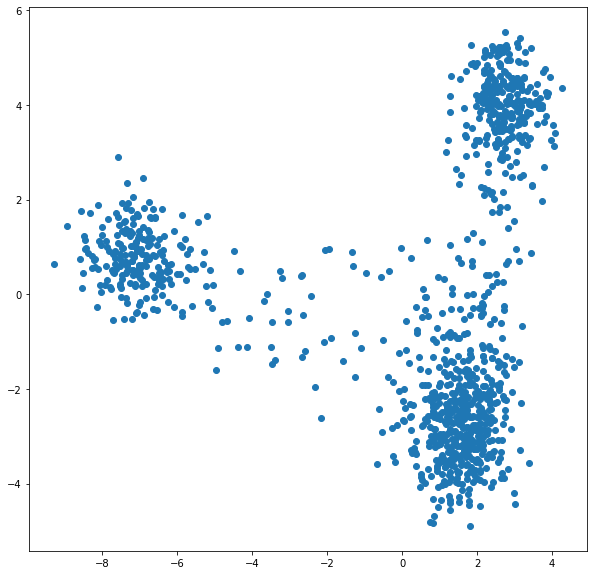

In [15]:
# Now lets visualize our data with this
# change of basis applied.

fig = plt.figure(figsize = (10, 10))

plt.scatter(PC1_plot, PC2_plot)

plt.show()

In [16]:
pop_test = df.loc["superpopulation_code"]

print(np.unique(pop_test))

['AFR' 'AMR' 'ASN' 'EUR']


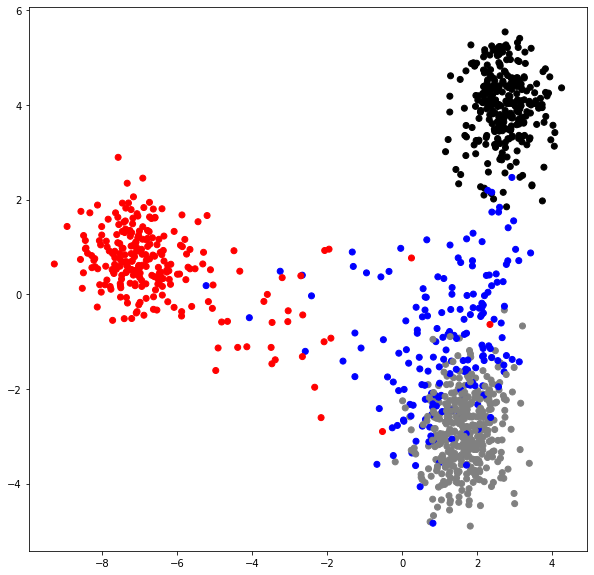

In [17]:
lookup = {
    "AFR": "red",
    "AMR": "blue",
    "ASN": "black",
    "EUR": "grey"
}

# Convert each anscestory to a color
# according to the map above.
colors = pop_test.map(lookup).tolist()

fig = plt.figure(figsize = (10, 10))

plt.scatter(PC1_plot, PC2_plot, color = colors)

plt.show()

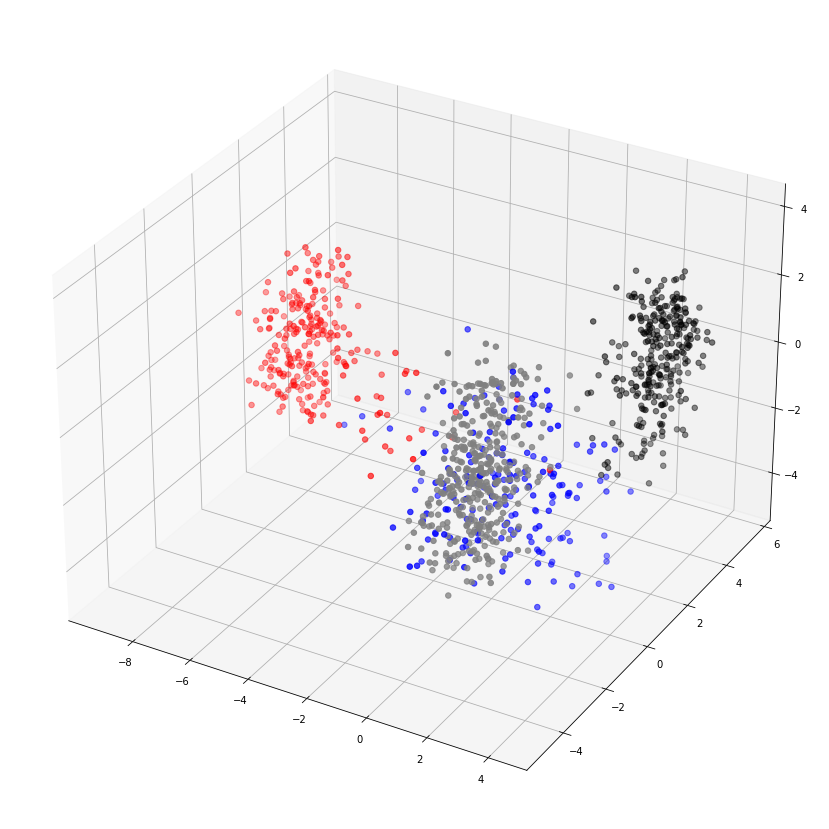

In [18]:
# Get the 3rd principle component.
PC3 = s[:, 2]

# 3rd change of basis.
PC3_plot = genotypes_normalized.T.dot(PC3)

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(projection = "3d")

ax.scatter(PC1_plot, PC2_plot, PC3_plot, color = colors, s = 30)

plt.show()